In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from seaborn import heatmap

In [2]:
sub_list_mand = ['FLT03', 'FLT05', ] #'FLT07', 'FLT08', 'FLT10', ] # 

sub_list_nman = ['FLT02', ] # 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13', ]

sub_list = sub_list_mand + sub_list_nman

In [3]:
project_dir = os.path.join('/Users/krs228', 'data', 'FLT')
bids_dir    = os.path.join(project_dir, 'data_bids')

In [4]:
sub_id = sub_list_nman[0]

In [5]:
bids_tsv_list = sorted(glob(bids_dir+'/sub-{}*.tsv'.format(sub_id)))

In [16]:
run_tsv = bids_tsv_list[0]
tsv_pd = pd.read_csv(run_tsv, sep='\t')

In [17]:
tsv_pd = tsv_pd[~tsv_pd['trial_type'].str.contains('resp_None')]

In [18]:
run_id = os.path.basename(run_tsv).split('_')[2]
print(run_id)

run-01


### Confusion matrix

In [19]:
simple_df = tsv_pd.loc[:,['trial_type', 'correct_key']].dropna()
simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]

simple_df['correct_key'] = simple_df['correct_key'].astype(int).astype(str)

simple_df['trial_type'] = [x[-1] for x in simple_df['trial_type']]

renum_simple_df = simple_df.astype(str).replace(['7', '6', '1', '2'], 
                                                ['1', '2', '3', '4'])

/var/folders/x3/sz0hgwdn1glgm8f611sj6tgw0000gn/T/ipykernel_75914/1558107547.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]


In [20]:
cm = confusion_matrix(renum_simple_df['correct_key'], renum_simple_df['trial_type'], normalize='true')
#np.savetxt('behav_confusion_matrices/sub-{}_tonecat_confusion_matrix.csv'.format(sub_id), cm)

'''
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay.from_predictions(renum_simple_df['correct_key'], renum_simple_df['trial_type'],  
                                               ax=ax,
                                               display_labels=['T1', 'T2', 'T3', 'T4'],
                                               cmap='Blues', colorbar=False, include_values=False,)
ax.set_title(sub_id)
#fig.savefig('behav_confusion_matrices/sub-{}_behav_confusion_matrix.png'.format(sub_id))
'''
print('sub-{} {} accuracy = {:.03f}'.format(sub_id, run_id, cm.diagonal().mean()))

sub-FLT02 run-01 accuracy = 0.403


### Behavioral RDMs

from Feng et al. (*NoL*):
> Learners’ response confusion matrices were created based on their categorization responses. If two sounds had an identical response, then this pair was coded as 0 in the confusion matrix; otherwise, it was coded as 1. Using this procedure, we created two confusion matrices in each block (one for each talker) for each learner. The two matrices were then averaged for each block. Finally, we calculated the Spearman’ s correlations (i.e., model fits) between each RDM and confusion matrices. We also examined the relationships between the RDM model fits and learning outcome and speed across subjects to see which RDM explains most of the interindividual variance in learning success.

In [21]:
stim_df = tsv_pd.loc[:,['trial_type', 'correct_key']]

# create a `stimulus` row
stim_df['stimulus'] = ''

# copy stimulus info to the response rows
for ix in range(1, len(stim_df)):
    if 'resp' in stim_df['trial_type'][ix]:
        stim_df['stimulus'].iloc[ix] = stim_df['trial_type'].iloc[ix-1].split('_')[1]

stim_df.dropna(inplace=True)

stim_df['trial_type'] = [x[-1] for x in stim_df['trial_type']]

stim_df['trial_type'] = stim_df['trial_type'].astype(str).replace(['7', '6', '1', '2'], 
                                                                  ['1', '2', '3', '4'])

stim_df['correct_key'] = stim_df['correct_key'].replace([7.0, 6.0, 1.0, 2.0], 
                                                        ['1', '2', '3', '4'])

/Users/KRS228/software/miniconda3/envs/py3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### compare responses across stimuli

In [22]:
stim_list = np.unique(stim_df[stim_df['stimulus'].str.contains('di')]['stimulus'])

# extract responses for each stimulus
all_stim_responses = []
for sx, stim in enumerate(stim_list):
    stim_responses = []
    for block in range(3):
        try:
            stim_responses.append(stim_df.loc[48*(block):48*(block+1)][stim_df['stimulus']==stim]['trial_type'].array[0])
        except:
            stim_responses.append(np.nan)
    all_stim_responses.append(stim_responses)

/var/folders/x3/sz0hgwdn1glgm8f611sj6tgw0000gn/T/ipykernel_75914/3388081672.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stim_responses.append(stim_df.loc[48*(block):48*(block+1)][stim_df['stimulus']==stim]['trial_type'].array[0])


In [23]:
# compare responses across stimuli
n_stim = len(all_stim_responses)
stim_conf_mat = np.zeros((n_stim, n_stim))
for srx in range(n_stim):
    for sry in range(n_stim):
        mean_val = np.mean([int(all_stim_responses[srx][x] == all_stim_responses[sry][x]) for x in range(3)])
        stim_conf_mat[srx, sry] = mean_val

# save output matrix
np.savetxt('sub-{}_{}_stimulus_confusion_matrix.tsv'.format(sub_id, run_id), stim_conf_mat, delimiter='\t')

In [24]:
stim_conf_mat

array([[0.33333333, 0.33333333, 0.        , 0.        , 0.        ,
        0.33333333, 0.33333333, 0.        , 0.33333333, 0.        ,
        0.33333333, 0.        , 0.        , 0.33333333, 0.        ,
        0.        ],
       [0.33333333, 1.        , 0.        , 0.        , 0.        ,
        0.33333333, 0.33333333, 0.66666667, 0.33333333, 0.        ,
        0.33333333, 0.        , 0.        , 0.33333333, 0.        ,
        0.33333333],
       [0.        , 0.        , 0.66666667, 0.33333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.33333333, 0.33333333, 0.66666667,
        0.33333333],
       [0.        , 0.        , 0.33333333, 0.66666667, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.33333333, 0.66666667, 0.33333333, 0.33333333,
        0.66666667],
       [0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.33333333, 

## Original analysis on direct psychopy log files (not BIDS-ified)

Ah! But my bids-converted events files don't include the actual button responses and what the expected correct response would be. Gotta go back to the source data....

In [3]:
raw_beh_dir = os.path.join('/bgfs/bchandrasekaran/krs228/',
                           'data/FLT/sourcedata/behav_files/',
                           'CHA-IBR/01-ToneLearning')

sub-FLT01 accuracy = 0.990
sub-FLT03 accuracy = 0.960
sub-FLT05 accuracy = 0.967
sub-FLT07 accuracy = 1.000
sub-FLT08 accuracy = 1.000
sub-FLT10 accuracy = 0.982
sub-FLT02 accuracy = 0.863
sub-FLT04 accuracy = 0.584
sub-FLT06 accuracy = 0.613
sub-FLT09 accuracy = 0.654
sub-FLT11 accuracy = 0.628
sub-FLT12 accuracy = 0.899
sub-FLT13 accuracy = 0.623


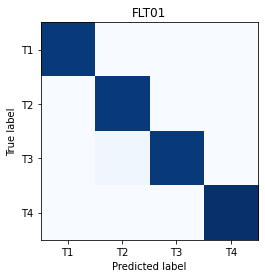

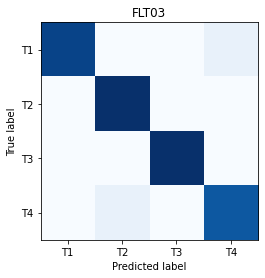

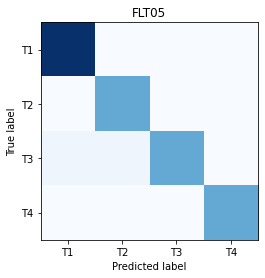

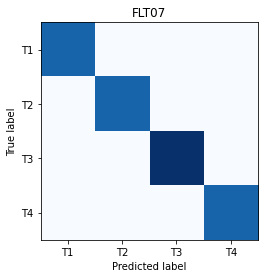

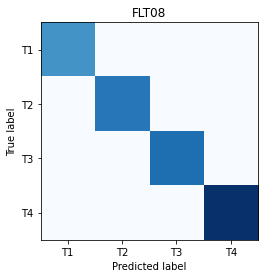

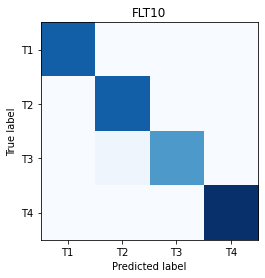

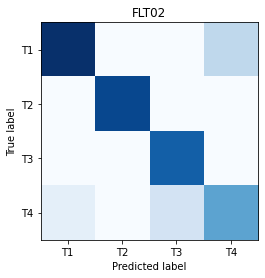

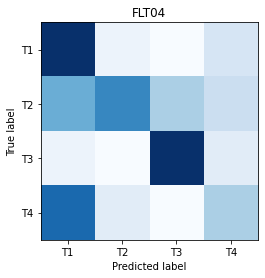

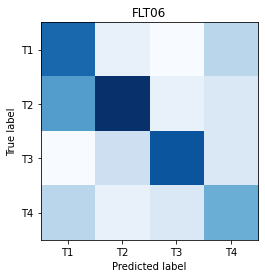

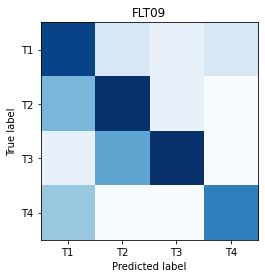

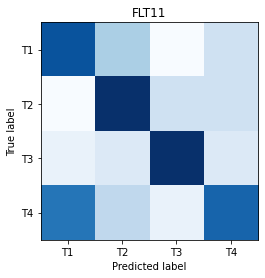

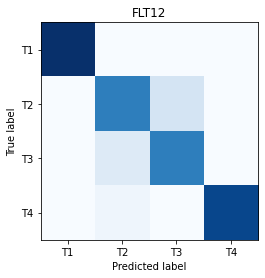

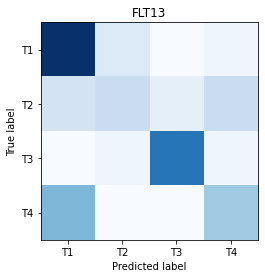

In [4]:
for sub_id in sub_list:
    file_list = sorted(glob(raw_beh_dir+'/sub-{}*tone_learning*.csv'.format(sub_id)))
    psy_list = []
    for rx, fpath in enumerate(file_list):
        psy_df = pd.read_csv(fpath, sep=',')

        psy_list.append(psy_df)
    all_df = pd.concat(psy_list)

    # just keep the critical data columns
    simple_df = all_df.loc[:,['key_resp.keys', 'corrAns']].dropna()

    simple_df['corrAns'] = simple_df['corrAns'].astype(int)

    renum_simple_df = simple_df.astype(str).replace(['7', '6', '1', '2'], 
                                                    ['1', '2', '3', '4'])

    renum_simple_df.drop(renum_simple_df[renum_simple_df['key_resp.keys']=='None'].index, inplace=True)
    renum_simple_df.drop(renum_simple_df[renum_simple_df['key_resp.keys']=='8'].index, inplace=True)
    renum_simple_df.drop(renum_simple_df[renum_simple_df['corrAns']=='0'].index, inplace=True)

    y_correct = np.array(renum_simple_df['corrAns'])
    y_response = np.array(renum_simple_df['key_resp.keys'])   

    cm = confusion_matrix(y_correct, y_response, normalize='true')
    #np.savetxt('behav_confusion_matrices/sub-{}_behav_confusion_matrix.csv'.format(sub_id), cm)

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay.from_predictions(y_correct, y_response,  ax=ax,
                                                   display_labels=['T1', 'T2', 'T3', 'T4'],
                                                   cmap='Blues', colorbar=False, include_values=False,)
    ax.set_title(sub_id)
    #fig.savefig('behav_confusion_matrices/sub-{}_behav_confusion_matrix.png'.format(sub_id))
    print('sub-{} accuracy = {:.03f}'.format(sub_id, cm.diagonal().mean()))

In [5]:
cm

array([[0.84615385, 0.11538462, 0.        , 0.03846154],
       [0.25      , 0.3125    , 0.125     , 0.3125    ],
       [0.        , 0.05555556, 0.88888889, 0.05555556],
       [0.55555556, 0.        , 0.        , 0.44444444]])

In [54]:
renum_simple_df['corrAns'].unique()

array(['4', '0', '3', '1', '2'], dtype=object)